@article{diode_dataset,
  title={{DIODE}: {A} {D}ense {I}ndoor and {O}utdoor {DE}pth {D}ataset},
  author={Igor Vasiljevic and Nick Kolkin and Shanyi Zhang and Ruotian Luo and
  Haochen Wang and Falcon Z. Dai and Andrea F. Daniele and Mohammadreza Mostajabi and
  Steven Basart and Matthew R. Walter and Gregory Shakhnarovich},
  journal={CoRR},
  volume={abs/1908.00463},
  year={2019},
  url={http ://arxiv.org/abs/1908.00463}
}

In [1]:
import os
import sys

import tensorflow as tf
from tensorflow.keras import layers

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

tf.random.set_seed(24)

In [2]:
annotation_folder = "/data/"
if not os.path.exists(os.path.abspath(".") + annotation_folder):
    annotation_zip = tf.keras.utils.get_file(
        "val.tar.gz",
        cache_subdir=os.path.abspath("."),
        origin="http://diode-dataset.s3.amazonaws.com/val.tar.gz",
        extract=True,
    )

2774625282/2774625282 [==============================] - 85s 0us/step


In [24]:
path = '/content/val/outdoor'

In [33]:
paths = []
for root, dirs, files in os.walk(path):
    for file in files:
        paths.append(os.path.join(root, file))

In [34]:
paths = np.sort(paths)

In [35]:
len(paths)

1338

In [54]:
def enhance_depth_map1(depth_map , mask):
  depth_map = np.load(depth_map).squeeze()
  mask = np.load(mask)
  mask = mask > 0
  max_depth = min(300, np.percentile(depth_map, 99))
  depth_map = np.clip(depth_map, 0.1, max_depth)
  depth_map = np.log(depth_map, where=mask)
  depth_map = np.ma.masked_where(~mask, depth_map)
  depth_map = np.clip(depth_map, 0.1, np.log(max_depth))
  depth_map = cv2.resize(depth_map, (256, 256))
  depth_map = np.expand_dims(depth_map, axis=2)
  depth_map = tf.image.convert_image_dtype(depth_map, tf.float32)
  return depth_map

In [53]:
from skimage import exposure

def enhance_depth_map2(depth_map_path, mask_path):
    # Load depth map and mask data
    depth_map = np.load(depth_map_path).squeeze()
    mask = np.load(mask_path)
    mask = mask > 0
    max_depth = min(300, np.percentile(depth_map, 99))
    depth_map = np.clip(depth_map, 0.1, max_depth)
    enhanced_depth_map = exposure.equalize_hist(depth_map, mask=mask)
    resized_depth_map = cv2.resize(enhanced_depth_map, (512, 512))
    expanded_depth_map = np.expand_dims(resized_depth_map, axis=2)
    converted_depth_map = tf.image.convert_image_dtype(expanded_depth_map, tf.float32)
    return converted_depth_map


In [68]:
def multi_scale_retinex(img, sigma_list, G, b, alpha, low_clip, high_clip):
    img = np.float64(img) + 1.0

    retinex = np.zeros_like(img)
    for sigma in sigma_list:
        gaussian = cv2.GaussianBlur(img, (G, G), sigma)
        retinex = retinex + np.log10(img) - np.log10(gaussian)

    retinex = alpha * retinex

    retinex = np.where(retinex < low_clip, low_clip, retinex)
    retinex = np.where(retinex > high_clip, high_clip, retinex)

    retinex = (retinex - np.min(retinex)) / (np.max(retinex) - np.min(retinex)) * 255
    retinex = np.uint8(retinex)

    return retinex

def enhance_depth_map_retinex(depth_map_path, mask_path, target_size=(512, 512), sigma_list=(15, 80, 250), G=15, b=25, alpha=125, low_clip=0, high_clip=255):
    depth_map = np.load(depth_map_path).squeeze()
    mask = np.load(mask_path)
    mask = mask > 0
    enhanced_depth_map = multi_scale_retinex(depth_map, sigma_list, G, b, alpha, low_clip, high_clip)
    resized_depth_map = cv2.resize(enhanced_depth_map, target_size)
    expanded_depth_map = np.expand_dims(resized_depth_map, axis=2)
    converted_depth_map = tf.image.convert_image_dtype(expanded_depth_map, tf.float32)

    return converted_depth_map


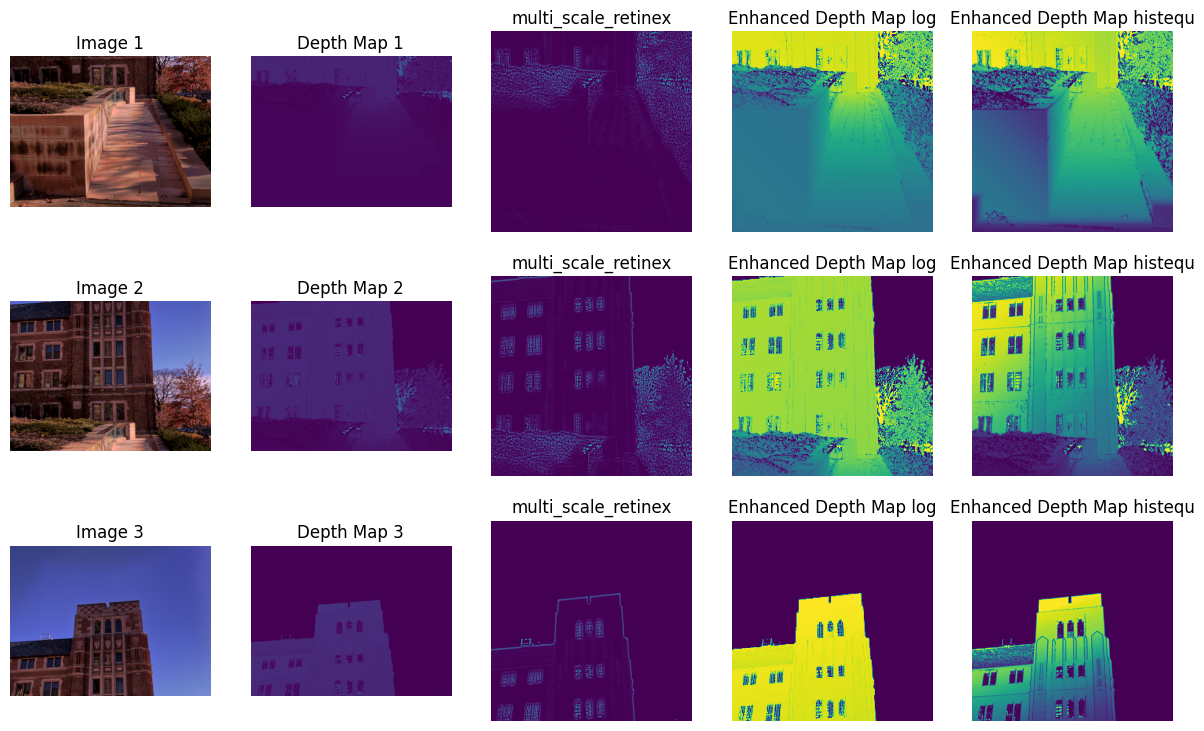

In [75]:
image_paths = [paths[i] for i in range(0 , 8 , 3)]  # Example image paths
depth_arrays = [np.load(paths[i+1]) for i in range(0 , 8 , 3)]
depth_mask_arrays = [np.load(paths[i+2]) for i in range(0 , 8 , 3)]
depth1 = [enhance_depth_map1(paths[i+1] , paths[i+2]) for i in range(0 , 8 , 3)]
depth2 = [enhance_depth_map2(paths[i+1] , paths[i+2]) for i in range(0 , 8 , 3)]
depth3 = [enhance_depth_map_retinex(paths[i+1] , paths[i+2]) for i in range(0 , 8 , 3)]

fig, axes = plt.subplots(len(image_paths), 5, figsize=(15, 3*len(image_paths)))
fig.subplots_adjust(wspace=0.2)

for i in range(len(image_paths)):
    image = plt.imread(image_paths[i])

    axes[i, 0].imshow(image)
    axes[i, 0].set_title('Image {}'.format(i + 1))
    axes[i, 0].axis('off')

    axes[i, 1].imshow(depth_arrays[i], cmap='viridis')
    axes[i, 1].set_title('Depth Map {}'.format(i + 1))
    axes[i, 1].axis('off')

    axes[i, 2].imshow(depth3[i], cmap='viridis')
    axes[i, 2].set_title('multi_scale_retinex')
    axes[i, 2].axis('off')

    axes[i, 3].imshow(depth1[i], cmap='viridis')
    axes[i, 3].set_title('Enhanced Depth Map log')
    axes[i, 3].axis('off')

    axes[i, 4].imshow(depth2[i], cmap='viridis')
    axes[i, 4].set_title('Enhanced Depth Map histequ')
    axes[i, 4].axis('off')



plt.show()


so the hist Histogram Equalization is choosed

# in progress...